# REINVENT

REINVENT is a generative model for molecules. Specifically, it is a SMILES-based generative model: it learns to write SMILES strings that correspond to valid, drug-like molecules. REINVENT starts from a model called the **prior**. The prior has been trained on lots of known, drug-like chemistry, so it already knows how to generate reasonable molecules (not just random junk). For optimization, we make a copy of the prior called the **agent**. The prior stays frozen as a reference for what “normal chemistry” looks like. The agent is the one we train. The whole point of REINVENT is to update the agent so it no longer just samples generic prior-like molecules, but instead starts generating molecules that match our design goals.

---

## How REINVENT learns

REINVENT uses reinforcement learning (RL) to steer the agent. Each RL step works like this:  
1. The agent samples a batch of SMILES (candidate molecules).  
2. Each SMILES is scored using our scoring function.  
3. The agent is updated so that high-scoring molecules become more likely next time, and low-scoring molecules become less likely.

This means the agent is literally being pushed toward “make more things like these good ones.” Over time, the distribution of molecules it generates moves toward the chemical space we’re asking for.

---

## Flavours of REINVENT

There are a few related models built on the same idea, but targeted at slightly different design problems:

- **REINVENT (what we're using here)**  
  - Generates complete molecules as SMILES from scratch.  
  - Can be steered toward arbitrary objectives (logP, QED, etc).  
  - Good for “give me novel drug-like molecules.”

- **LibINVENT**  
  - Generates virtual libraries around a common scaffold or core.  
  - You fix the core, and it proposes R-group decorations / substitutions.  
  - Good for “enumerate medicinal chemistry ideas around this series.”

- **LinkINVENT**  
  - Generates linkers between two fragments.  
  - Think: you have fragment A and fragment B bound in a pocket and you want a linker that connects them.  
  - Good for fragment linking / PROTAC linker design / bridging warheads.

- **Mol2Mol**  
  - Takes an input molecule and proposes a new related molecule.  
  - More like “transform this” than “generate from nothing.”  
  - Good for scaffold hopping, analogue generation, and lead optimization.

They all share the same high-level loop — generate candidate → score it → learn to make better ones — but differ in what exactly is being generated (full molecule vs decoration vs linker vs modified version of an input).

---

## Scoring functions

The scoring function is how we tell REINVENT what “good” means. We define it in a TOML file (for example `slogp_max.toml` or `druglike.toml`) as a set of scoring components. Typical components include:
- logP (lipophilicity)
- molecular weight
- H-bond donors / H-bond acceptors
- TPSA (polarity / permeability)
- QED (drug-likeness)
- synthetic accessibility (is it insane to make?)

For each component, REINVENT does two things:
1. It calculates the raw property of the molecule (for example “TPSA = 74 Å²” or “HBD = 1”).
2. It transforms that property into a desirability score between 0 and 1. That transform can mean “higher is better,” “lower is better,” or “a middle range is best.”

All component scores are then combined into a single final score called `Score`. That final `Score` is used as the reward for RL. In other words: the agent is trained to generate SMILES with a high `Score`.

---

## What we will do

1. **Run `slogp_max.toml`**  
   We ask REINVENT to generate molecules with high logP. This is a simple, single-objective case so you can clearly see that the model can be pushed in a specific direction.

2. **Run `druglike.toml`**  
   We ask REINVENT to generate molecules that look more generally drug-like. This version balances multiple properties at once (size, polarity, H-bonding, etc.) instead of just chasing one thing.

3. **Inspect the results**  
   REINVENT writes a CSV (e.g. `output/run_1.csv` or `output/druglike_1.csv`) that includes:
   - the generated SMILES,
   - each property score (both raw values and transformed 0–1 values),
   - the final `Score`,
   - and which RL step it came from.

We will:
- plot how the average score changes over RL steps,
- and visualise example molecules from different stages of training,
  so you can literally see the chemistry shift toward what we asked for.


In [1]:
from pathlib import Path
import subprocess, shlex, os

# make sure output dir exists
Path("output").mkdir(exist_ok=True)

CONFIG_PATH = Path("druglike.toml").resolve()
PRIOR_PATH  = Path("reinvent.prior").resolve()
LOG_PATH    = Path("output/run.log").resolve()


assert CONFIG_PATH.exists(), "Missing slogp_max.toml"
assert PRIOR_PATH.exists(),  "Missing reinvent.prior"

cmd = f"reinvent -l {LOG_PATH.as_posix()} {CONFIG_PATH.as_posix()}"
print("Launching:", cmd)

rl_proc = subprocess.Popen(
    shlex.split(cmd),
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT,
    text=True
)

print("REINVENT running with PID:", rl_proc.pid)


Launching: reinvent -l /home/runcie/Documents/teaching/output/run.log /home/runcie/Documents/teaching/druglike.toml
REINVENT running with PID: 1298993


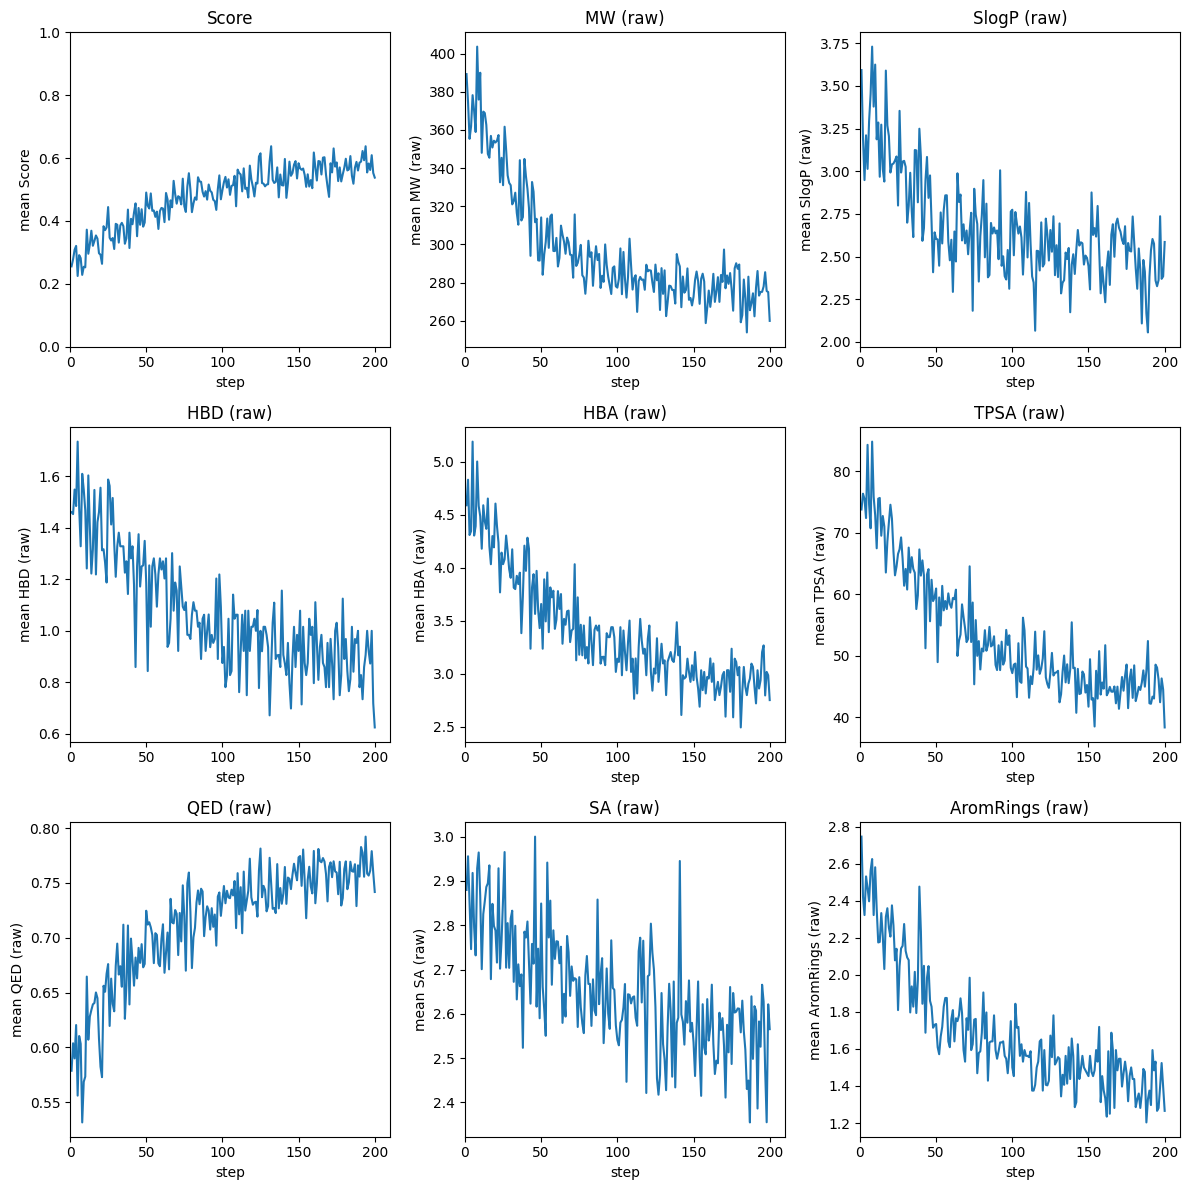

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import math

SHOW_RAW = True  # True = plot "... (raw)" columns, False = plot transformed columns

# load + keep valid molecules only once
df = pd.read_csv("output/druglike_1.csv")
df = df[df["SMILES_state"] == 1].copy()

# figure out which metric columns to plot
if SHOW_RAW:
    metric_cols = [c for c in df.columns if c.endswith("(raw)")]
else:
    raw_pairs = [(c, c.replace(" (raw)", "")) for c in df.columns if c.endswith("(raw)")]
    metric_cols = [t for _, t in raw_pairs if t in df.columns]

# always include Score first
plot_cols = ["Score"] + [c for c in metric_cols if c != "Score"]

# compute per-step means for each column once
step_means = {}
for col in plot_cols:
    tmp_col = pd.to_numeric(df[col], errors="coerce")
    step_means[col] = (
        pd.DataFrame({"step": df["step"], col: tmp_col})
        .groupby("step", as_index=False)[col]
        .mean()
        .sort_values("step")
    )

# make grid with 3 columns per row
n = len(plot_cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

plt.figure(figsize=(12, 4*rows))
for i, col in enumerate(plot_cols, start=1):
    ax = plt.subplot(rows, cols_per_row, i)
    ax.plot(step_means[col]["step"], step_means[col][col])
    ax.set_xlabel("step")
    ax.set_ylabel(f"mean {col}")
    ax.set_title(col)
    ax.set_xlim(left=0)
    if (col == "Score") or (not SHOW_RAW):
        ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


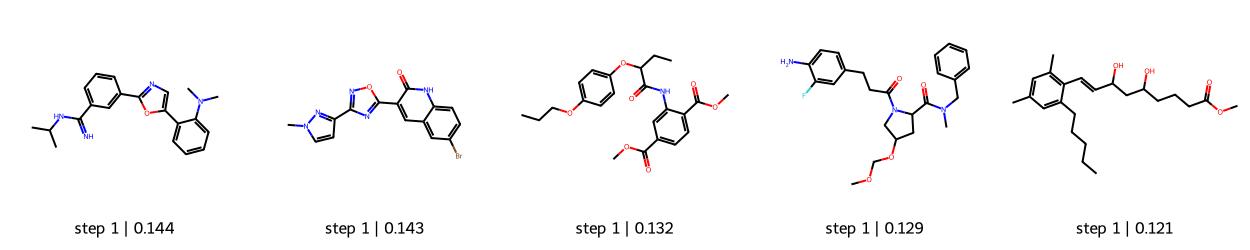

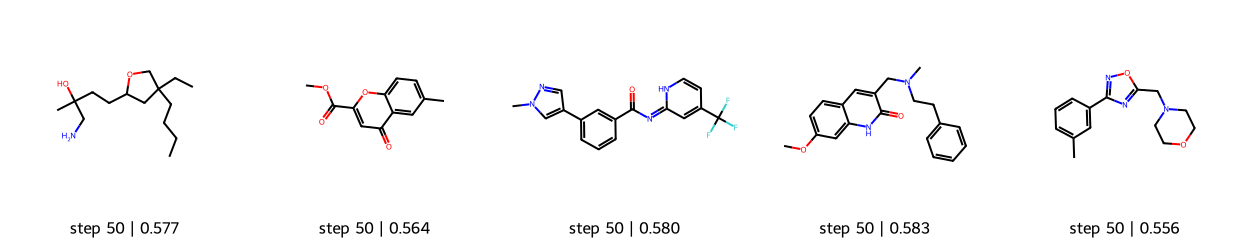

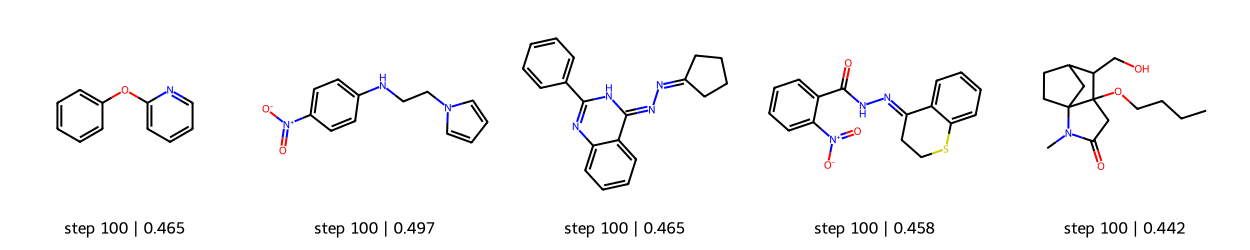

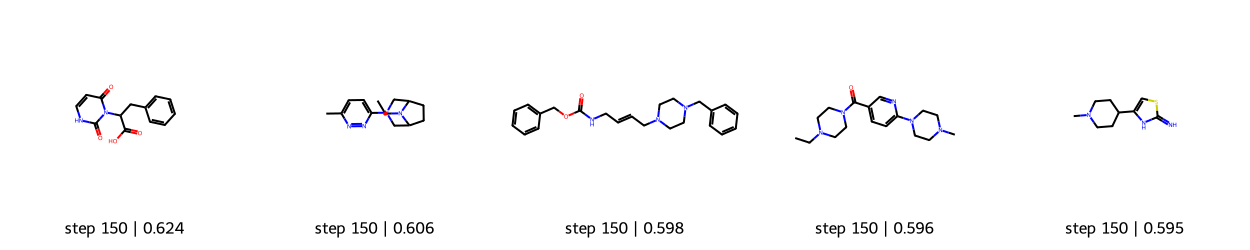

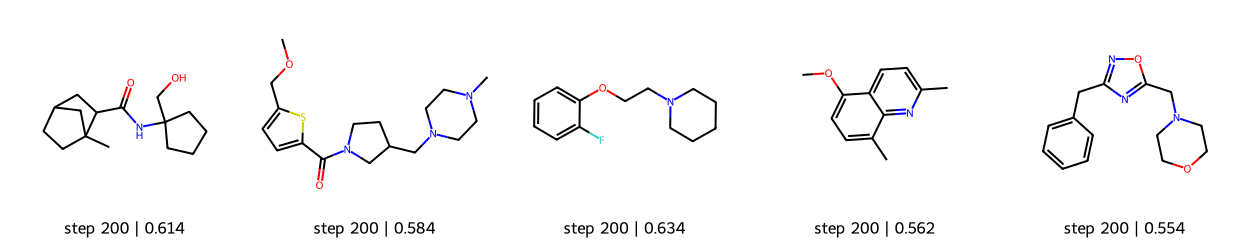

In [11]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

steps = sorted(df["step"].unique())
picked = sorted({steps[i] for i in np.linspace(0, len(steps)-1, 5).astype(int)})

for step in picked:
    sub = df[df["step"] == step].copy()
    med = sub["Score"].median()
    sub["dist"] = (sub["Score"] - med).abs()
    mid5 = sub.sort_values("dist").head(5)
    mols = [Chem.MolFromSmiles(s) for s in mid5["SMILES"]]
    legends = [f"step {step} | {x:.3f}" for x in mid5["Score"]]
    display(Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250), legends=legends))
